In [ ]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, Bidirectional
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras import optimizers

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
# DATASET
DATASET_ENCODING = "ISO-8859-1"
DATASET_COLUMNS = ["sentiment", "ids", "date", "flag", "user", "text"]

TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 128

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "teacher_model.h5"
WORD2VEC_MODEL = "w2v_model.w2v"
TOKENIZER_MODEL = "teacher_tokenizer.pkl"
ENCODER_MODEL = "teacher_encoder.pkl"

In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Data science/cp_dataset/labelled_tweets_1.csv",
                 encoding = DATASET_ENCODING)

In [ ]:
df

,text,sentiment
0,âvirus leak from hotel quarantine which be m...,1
1,the doctor and a sexy fish stay at a hotel in ...,4
2,hotel emporium have create the perfect replace...,5
3,sunainapatnaik sloganmurugan you have to pay r...,1
4,worldâs first hotel which run on electricity...,5
...,...,...
9995,i have kerry birthday on the kailee birthday o...,4
9996,leave baueroutage at the hotel the sexual pred...,1
9997,zachmortice bagnese a five star hotel and expl...,1
9998,the violet steve hotel amaze sight on what the...,5


In [ ]:
df['sentiment'] = df['sentiment'].replace(2,1)
df['sentiment'] = df['sentiment'].replace(4,5)
df.drop(df[df['sentiment'] == 3].index, inplace = True)

2021-09-13 09:41:06,515 : INFO : NumExpr defaulting to 2 threads.


In [ ]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
stop_words = stopwords.words("english")
nltk.download('sentiwordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.


True

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tag import pos_tag

def preprocess(text, lem=True):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    lemmatizer = WordNetLemmatizer()
    split_text = text.split()
    tokens = []
    if lem:
        for word, tag in pos_tag(split_text):
            if tag.startswith('NN'):
                pos = 'n'
            elif tag.startswith('VB'):
                pos = 'v'
            else:
                pos = 'a'
            tokens.append(lemmatizer.lemmatize(word, pos))
    else:
        tokens.append(split_text)
    return " ".join(tokens)

In [ ]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 11.2 s, sys: 220 ms, total: 11.4 s
Wall time: 11.4 s


In [ ]:
def preprocessno(text):
    text = re.sub(r'[0-9]', ' ', str(text).lower()).strip()
    return (text)

In [ ]:
%%time
df.text = df.text.apply(lambda x: preprocessno(x))

CPU times: user 26.1 ms, sys: 0 ns, total: 26.1 ms
Wall time: 26.1 ms


In [ ]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 7073
TEST size: 1769


In [ ]:
df["sentiment"].unique()

array([1, 5])

In [ ]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords.append("hotel")
stopwords.append("room")
stopwords.append("get")
stopwords.append("go")
stopwords.append("stay")
stopwords.append("one")

In [ ]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

def remove_stopwords(text):
    tokenized_text = tokenizer.tokenize(text)
    text = [w for w in tokenized_text if w not in stopwords]
    combined_text = ' '.join(text)
    return combined_text

df.text = df.text.apply(str).apply(lambda x: remove_stopwords(x))

In [ ]:
documents = df["text"].apply(lambda x:str(x).split())
top = Counter([item for sublist in documents for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,like,425
1,quarantine,422
2,amp,413
3,new,306
4,book,280
5,day,267
6,say,253
7,time,242
8,look,242
9,take,238


In [ ]:
df1 =df[(df['sentiment'] == 1)]
df2 =df[(df['sentiment'] == 5)]

(-0.5, 399.5, 199.5, -0.5)

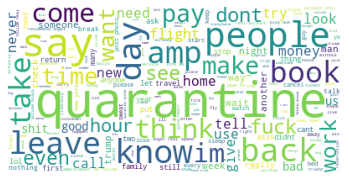

In [ ]:
from wordcloud import WordCloud

wordcloud1 = WordCloud( background_color='white').generate(" ".join(df1.text))
plt.imshow(wordcloud1)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

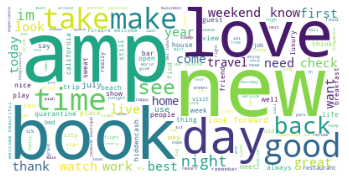

In [ ]:
wordcloud2 = WordCloud( background_color='white').generate(" ".join(df2.text))
plt.imshow(wordcloud2)
plt.axis('off')

In [ ]:
print("Dataset size:", len(df))

Dataset size: 8842


In [ ]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 15018
CPU times: user 178 ms, sys: 1.76 ms, total: 180 ms
Wall time: 188 ms


In [ ]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=128)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=128)

CPU times: user 209 ms, sys: 13.3 ms, total: 222 ms
Wall time: 212 ms


In [ ]:
encoder = LabelEncoder()
encoder.fit(df_train.sentiment.tolist())

y_train = encoder.transform(df_train.sentiment.tolist())
y_test = encoder.transform(df_test.sentiment.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (7073, 1)
y_test (1769, 1)


In [ ]:
embedding_layer = Embedding(vocab_size, 128, 
                            input_length=128, trainable=True)

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Bidirectional(LSTM(128,  return_sequences=True)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 128, 128)          1922304   
_________________________________________________________________
bidirectional (Bidirectional (None, 128, 256)          263168    
_________________________________________________________________
dropout (Dropout)            (None, 128, 256)          0         
_________________________________________________________________
dense (Dense)                (None, 128, 1)            257       
Total params: 2,185,729
Trainable params: 2,185,729
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer="Adam",
              metrics=['accuracy'])

In [ ]:
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 1,
                                        restore_best_weights = True)

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=25,
                    validation_split=0.3,
                    verbose=1,
                    callbacks=[earlystopping])

Epoch 1/25
39/39 [==============================] - 42s 992ms/step - loss: 0.6788 - accuracy: 0.5856 - val_loss: 0.6918 - val_accuracy: 0.5708
Epoch 2/25
39/39 [==============================] - 38s 968ms/step - loss: 0.6744 - accuracy: 0.5952 - val_loss: 0.6758 - val_accuracy: 0.5840
Epoch 3/25
39/39 [==============================] - 37s 958ms/step - loss: 0.5669 - accuracy: 0.7411 - val_loss: 0.5546 - val_accuracy: 0.7516
Epoch 4/25
39/39 [==============================] - 38s 972ms/step - loss: 0.4093 - accuracy: 0.8577 - val_loss: 0.5581 - val_accuracy: 0.7632
CPU times: user 4min 29s, sys: 19.8 s, total: 4min 48s
Wall time: 2min 35s


In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

14/14 [==============================] - 4s 252ms/step - loss: 0.5523 - accuracy: 0.7547

ACCURACY: 0.7547078132629395
LOSS: 0.5523256659507751
CPU times: user 6.56 s, sys: 385 ms, total: 6.95 s
Wall time: 53.3 s


In [ ]:
#def predict(text):
#    start_at = time.time()
#    # Tokenize text
#    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=128)
    # Predict
#    score = model.predict([x_test])


#    return (score) 

In [ ]:
model.save("project_model.h5")